### Support vector machines

We are given a dataset of N points with labels $y_i=$ +1 or -1 and we want to build a classifier for them. One way to do that is to find a line (hyper-plane in higher dimensions) that separates the dataset. There may be many such lines (or none, in which case we say that the dataset is not linearly seperable), so we want to define a criterion for which one is best. Support vector machines define that to be the line that produces the largest margin (the margin is the distance between the line and the closest point). More specifically, if we define the line through a vector $\textbf{w}$ orthogonal to it, and bias $b$, we want to minimise $||\textbf{w}||$ (thus maximising the margin $\frac{1}{||\textbf{w}||}$), such that $\textbf{w}^T\textbf{x} > 1$ when $y_i=1$ and $<1$ otherwise. For short, we can rewrite this as $y_i(\textbf{w}^T\textbf{x} - b) \geq 1$ for all $1\leq i \leq N$. Now, we want this to be applicable to cases when the data is non-linearly seperable, so we can replace that expression with $max(0,1 - y_i(\textbf{w}^T\textbf{x} - b))$, called the hinge loss. This last expression is 0 if the constaint is satisfied, thus not contributing to the loss.



<img src="resources/SVM_margin.png" style="height:300px">

The problem as defined above is solved by a $\textbf{w}$ which satisfies the equation $\textbf{w} = \sum_{i=1}^N c_i y_i \textbf{x}_i$, for some constants $c_i$. This is an interesting result, as it shows that $\textbf{w}$ is just a weighted sum of the input vectors $\textbf{x}_i$ (remember $y_i$ is either $-1$ or $+1$. What's more, it turns out that the $c_i$s are $0$ when the point is on the correct side of the margin, thus, assuming we classify everything right, the only contributions come from points on the boundary of the margin. These points are called support vectors, thus the name of the method.

### Let's see this in code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [2]:
# import some data to play with
iris = datasets.load_iris()
# Take the first two features only so we can visualise better
X = iris.data[:, :2]
y = iris.target

# We're making a binary classifier
mask = np.where(np.logical_or(y == 0, y == 2))
X = X[mask]
y = y[mask]

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

### Side note: Complexity regularisation

In some problems, such as in SVMs, our problem is under-defined and allows for multiple solutions. The way we often deal with that in machine learning is by imposing additional constraints on the problem. In this case, there are many vectors $\textbf{w}$ that produce the same loss. However, the bigger $||\textbf{w}||$ is, the quicker our function varies as we change of our input - thus it can capture more complex relationships. We want to employ the idea of _Occam's razor_ here, so we further penalise solutions with larger $||\textbf{w}||$. This is controlled by the hyperparameter $C$, or often denoted by $\lambda$.

In [5]:
C = 1.0  # SVM regularization parameter

Text(0.5, 1.0, 'LinearSVC (linear kernel)')

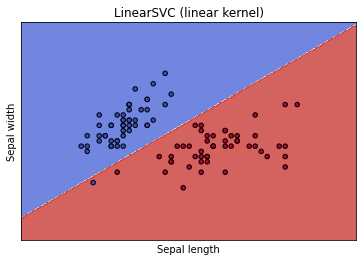

In [24]:
model = svm.LinearSVC(C=C)
model = model.fit(X, y)
title = 'LinearSVC (linear kernel)'

fig, ax = plt.subplots(1, 1)
plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

The learned classifier may remind you of logistic regression, however note that in logistic regression, the classifier outputs values between 0 and 1, where here it can output any positive value.

### Making non-linear boundaries

Now, the above allows us to only fit lines. However, this is rarely the best separator fo data, so we will make use of the **kernel trick**. This trick is applicable whenever we have only the dot products of datapoints, which is exactly the case for SVMs (what does $\textbf{w}^T\textbf{x}$ look like at the best solution?). 

We can imagine replacing our input data $\textbf{x}$ with some transformation of it $\boldsymbol{\phi}(\textbf{x})$. For example, $\boldsymbol{\phi}(\textbf{x}) = [1, x_1, x_2 x_3, \sqrt{x_7}]$. Then, our solution for the SVM will be $\textbf{w} = \sum_{i=1}^N c_i y_i \boldsymbol{\phi}(\textbf{x}_i)$ and when we want to make a prediction, we will get $\textbf{w}^T \boldsymbol{\phi}(\textbf{x}_*) = \sum_{i=1}^N c_i y_i \boldsymbol{\phi}(\textbf{x}_i)^T \boldsymbol{\phi}(\textbf{x}_*) = \sum_{i=1}^N c_i y_i k(\textbf{x}_i, \textbf{x}_*)$, where $k(\textbf{x}_i, \textbf{x}_*) = \boldsymbol{\phi}(\textbf{x}_i)^T \boldsymbol{\phi}(\textbf{x}_*)$. Now, in the above example, we knew what $\boldsymbol{\phi}$ does, but in general we don't need to know it explicitly, as long as we know the kernel $k$. Next, we will look at two kernels - the RBF kernel $k_{\gamma}(x, y) = exp(-\gamma||\textbf{x}-\textbf{y}||^2)$, and the polynomial kernel $k_{p} = (\textbf{x}^T\textbf{y})^p$.

Text(0.5, 1.0, 'SVC with RBF kernel')

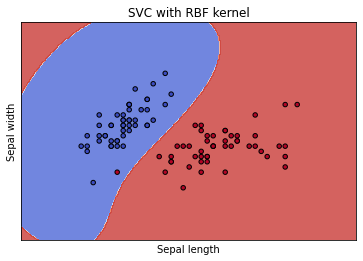

In [20]:
model = svm.SVC(kernel='rbf', gamma=0.7, C=C)
model = model.fit(X, y)
title = 'SVC with RBF kernel'

fig, ax = plt.subplots(1, 1)
plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

Note that the boundary is now highly non-linear!

Now try the polynomial kernel of degree 3 for the same dataset.

Text(0.5, 1.0, 'SVC with polynomial (degree 3) kernel')

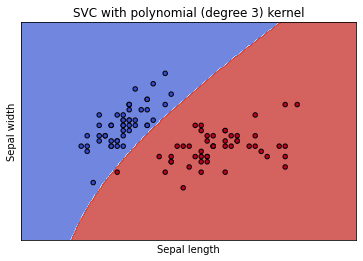

In [21]:
model = svm.SVC(kernel='poly', degree=3, C=C)
model = model.fit(X, y)
title = 'SVC with polynomial (degree 3) kernel'

fig, ax = plt.subplots(1, 1)
plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

### Task

Play with different kernels https://sklearn.org/modules/svm.html#kernel-functions to try and fit the dataset below.

In [2]:
# Take another two features of the iris dataset
X = iris.data[:, 2:4]
y = iris.target

# We're making a binary classifier
mask = np.where(np.logical_or(y == 1, y == 2))
X = X[mask]
y = y[mask]

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

Text(0.5, 1.0, 'SVC with RBF kernel')

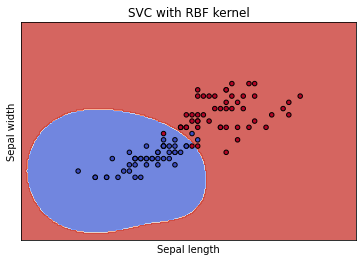

In [42]:
model = svm.SVC(kernel='rbf', gamma=2)
model = model.fit(X, y)
title = 'SVC with RBF kernel'

fig, ax = plt.subplots(1, 1)
plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

### Sums and products of kernels

Kernels have the nice property seen in lectures, that their sums and products are still valid kernels. Let's see what we can do with that!

Text(0.5, 1.0, 'SVC with polynomial (degree 3) kernel')

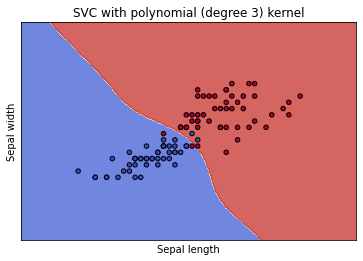

In [41]:
def sum_kernel(X, Y):
    gamma = 2
    K = np.zeros((X.shape[0], Y.shape[0]))
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            k_1 = np.exp(-gamma * np.sum((x-y)**2))
            k_2 = x.dot(y)
            K[i, j] = k_1 + k_2
    return K
            
from sklearn.metrics.pairwise import euclidean_distances
def gaussian_kernel(X, Y):
    gamma=2
    kernel = euclidean_distances(X, Y) ** 2
    kernel = -gamma*kernel
    kernel = np.exp(kernel)
#     kernel += X.dot(Y.T)
    return kernel
    
# model = svm.SVC(kernel=gaussian_kernel, max_iter = 10000)
model = svm.SVC(kernel=sum_kernel, max_iter = 10000)
model = model.fit(X, y)
title = 'SVC with polynomial (degree 3) kernel'

fig, ax = plt.subplots(1, 1)
plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

### Next steps

This is where you can go wild. Try different kernels on dif